In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 22px;
</style>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# warnings.filterwarnings('ignore')


In [5]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-09-20 21:14:08.714218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-20 21:14:08.714276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: deneb
2023-09-20 21:14:08.714281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: deneb
2023-09-20 21:14:08.714422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2023-09-20 21:14:08.714443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2023-09-20 21:14:08.714448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1


## Parameter Data

In [6]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 279
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_data_para = weight[:-1,:]
y_data_para = weight[1:,:]

for training_id in range(1, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_data_para = np.concatenate((x_data_para, weight[:-1,:]), axis = 0)
    y_data_para = np.concatenate((y_data_para, weight[1:,:]), axis = 0)

In [7]:
from sklearn.model_selection import train_test_split
x_train_para, x_test_para, y_train_para, y_test_para = train_test_split(x_data_para, y_data_para, test_size = 0.33)

In [8]:
np.shape(x_train_para)

(9192, 466)

In [9]:
from sklearn.preprocessing import StandardScaler
para_scaler = StandardScaler()
para_scaler.fit(x_train_para)
x_train_para_scaled = para_scaler.transform(x_train_para)
y_train_para_scaled = para_scaler.transform(y_train_para)
x_test_para_scaled = para_scaler.transform(x_test_para)
y_test_para_scaled = para_scaler.transform(y_test_para)

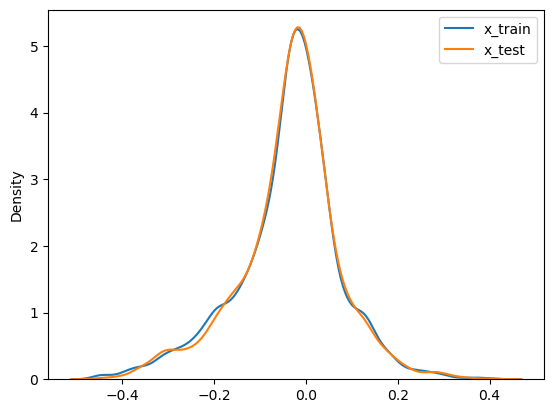

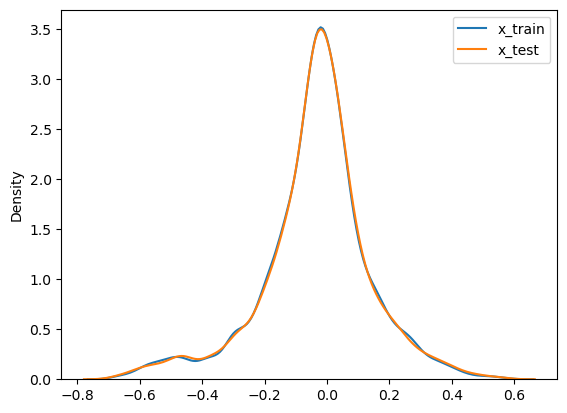

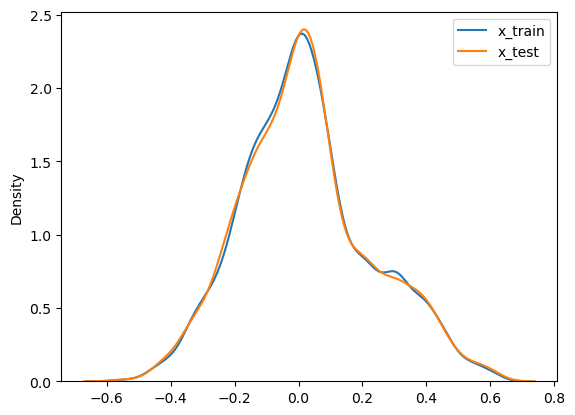

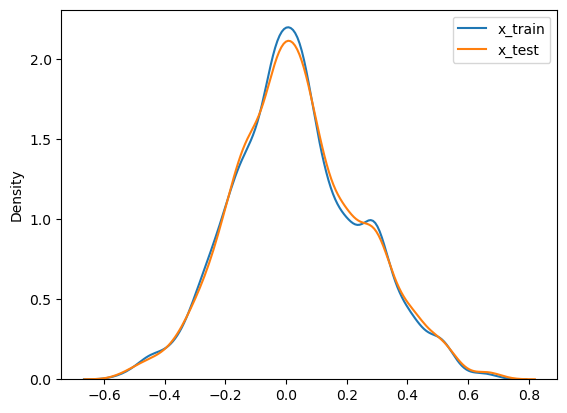

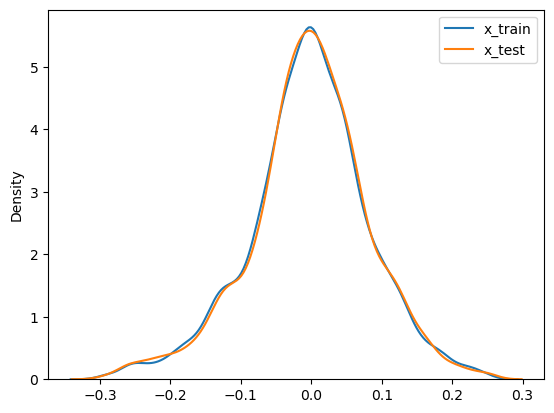

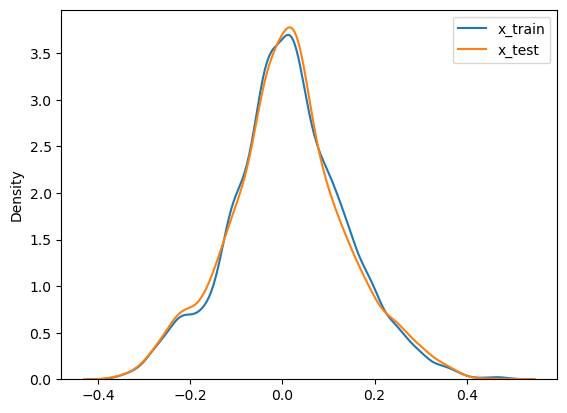

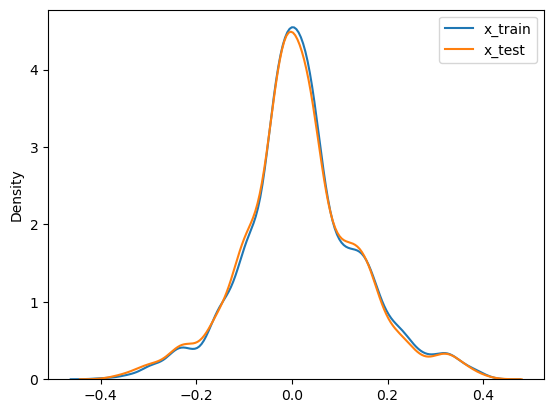

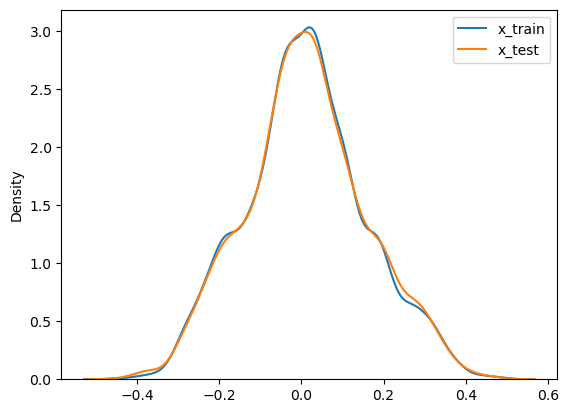

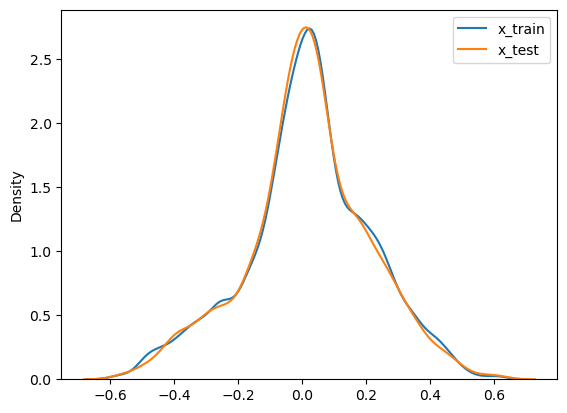

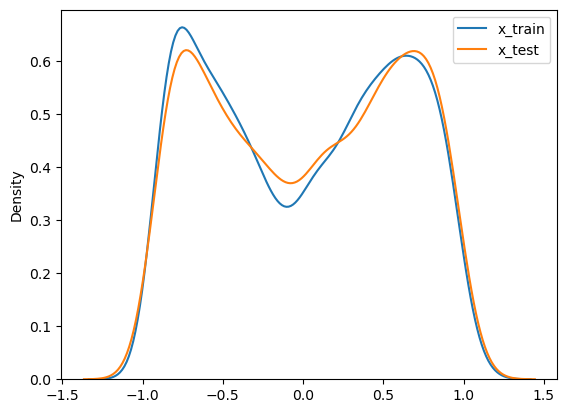

[394, 174, 86, 82, 295, 281, 282, 262, 7, 443]


In [10]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_para[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_para[:, random_number], label = 'x_test')
    plt.legend()
    plt.show()
    
print(random_numbers)

In [11]:
x_train_para

array([[ 0.10552688,  0.03130407,  0.10374456, ...,  0.7883994 ,
         0.07321272, -0.0397328 ],
       [-0.2058479 , -0.04114836,  0.5632993 , ...,  0.90504223,
         0.6352625 , -0.66073734],
       [ 0.02467883, -0.04080365, -0.03160509, ...,  0.02747778,
         0.03264565,  0.04137361],
       ...,
       [ 0.05472296,  0.03439901, -0.07522244, ...,  0.15240368,
         0.06315583, -0.08790857],
       [ 0.04606668,  0.18292487, -0.5311725 , ..., -0.8139889 ,
         0.4250683 , -0.48738733],
       [ 0.01018841, -0.06349418,  0.01131692, ..., -0.10980108,
        -0.06448829,  0.03272215]], dtype=float32)

In [12]:
permuted_indices = np.random.permutation(x_train_para.shape[0])
x_train_para_scaled = x_train_para_scaled[permuted_indices, :]
y_train_para_scaled = y_train_para_scaled[permuted_indices, :]

# Mnist Data and Model

In [13]:
from sklearn.decomposition import PCA

# Load MNIST data.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train_mnist))
x_train_mnist, y_train_mnist = x_train_mnist[shuffle_index], y_train_mnist[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train_mnist = (y_train_mnist < 5)
y_test_mnist = (y_test_mnist < 5)

# Convert labels to one-hot encoding.
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist)
y_test_mnist = tf.keras.utils.to_categorical(y_test_mnist)

# Instantiate the training dataset.
x_train_mnist = np.reshape(x_train_mnist, (-1, 784))
x_test_mnist = np.reshape(x_test_mnist, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 95% of variance
x_train_reduced_mnist = pca.fit_transform(x_train_mnist.reshape(x_train_mnist.shape[0], -1))
x_test_reduced_mnist = pca.transform(x_test_mnist.reshape(x_test_mnist.shape[0], -1))

In [14]:
x_combined_reduced_mnist = np.concatenate((x_train_reduced_mnist, x_test_reduced_mnist), axis=0)
y_combined_reduced_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

In [15]:
from tensorflow import keras

inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model_mnist = keras.Model(inputs=inputs, outputs=outputs, name = 'model_mnist')

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model_mnist.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])

2023-09-20 21:15:38.873314: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model_mnist.summary()

Model: "model_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 16)                432       
                                                                 
 predictions (Dense)         (None, 2)                 34        
                                                                 
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


# Parameter Model

In [17]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.executing_eagerly()

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[128,128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Subtract
from tensorflow.keras.models import Model

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, layer_weights, layer_biases, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.layer_weights = tf.Variable(layer_weights, trainable=True)
        if layer_biases is not None:
            self.layer_biases = tf.Variable(layer_biases, trainable=True)
        else:
            self.layer_biases = None

    def call(self, inputs):
        outputs = tf.matmul(inputs, self.layer_weights)
        if self.layer_biases is not None:
            outputs = tf.add(outputs, self.layer_biases)
        return outputs
    
class para_loss(tf.keras.layers.Layer):
    def __init__(self, lbd, model, x_data, y_data):
        super(para_loss, self).__init__()
        self.lbd = lbd
        self.model = model
        self.x_data = x_data
        self.y_data = y_data
        self.layer_weights = []
        self.layer_biases = []

        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                self.layer_weights.append(tf.Variable(weights[0], trainable=True))
                self.layer_biases.append(tf.Variable(weights[1], trainable=True))
            else:
                self.layer_weights.append(None)
                self.layer_biases.append(None)

    def call(self, parameter_set):
        start_index = 0
        model_loss = []
        for j in range(tf.shape(parameter_set)[0]):
            parameter = parameter_set[j,:]
            start_index = 0
            for i, layer in enumerate(self.model.layers):
                weights = self.layer_weights[i]
                biases = self.layer_biases[i]
                if weights is not None:
                    weights_shape = weights.shape
                    weights_size = tf.size(weights)
                    self.layer_weights[i].assign(tf.reshape(parameter[start_index:start_index + weights_size], weights_shape))
                    start_index += weights_size
        
                if biases is not None:
                    biases_shape = biases.shape
                    biases_size = tf.size(biases)
                    self.layer_biases[i].assign(tf.reshape(parameter[start_index:start_index + biases_size], biases_shape))
                    start_index += biases_size
                    
                weights_layer = layer.get_weights()
                if len(weights_layer) > 0:
                    layer.set_weights([self.layer_weights[i].numpy(), self.layer_biases[i].numpy()])
            
            with tf.GradientTape() as tape:
                model_output = self.model(self.x_data)
                loss_j = tf.keras.losses.MSE(model_output, self.y_data)
                model_loss.append(loss_j)
            tf.concat(model_loss, axis=0)
        return model_loss
    
    def loss_fun(self, y_true, y_pred):
        y_true_auto, y_true_koopman = y_true[0], y_true[1]
        y_pred_auto, y_pred_koopman = y_pred[0], y_pred[1]
        mse_loss = tf.keras.losses.MeanSquaredError()
        koopman_loss = mse_loss(y_true_koopman, y_pred_koopman)
        auto_loss = self.lbd * mse_loss(self.call(y_true_auto), self.call(y_pred_auto))
        loss = koopman_loss + auto_loss
        return loss, koopman_loss, auto_loss
    

def Build_model(loss, x_train_para, n_psi_train = 466):
    dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = n_psi_train)
    inputs_x = Input((np.shape(x_train_para)[1],))
    model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')
    
    inputs_x = Input((np.shape(x_train_para)[1],))
    inputs_y = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    psi_y = model_psi(inputs_y)
    k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
    outputs_x = k_layer(psi_x)
    outputs = outputs_x - psi_y
    model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')
    
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    inputs_kpsi = Input((dic.n_psi_train,))
    model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
    model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x), name = 'model_auto')
    
    input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
    input_y = tf.keras.layers.Input(shape=(y_train_para.shape[1],))
    output_auto = model_auto(input_x)
    output_koopman = model_koopman([input_x, input_y])
    combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman], name = 'model_combined')
    
    return model_psi, model_koopman, model_auto, combined_model

In [103]:
# import keras.backend as K
# tf.config.run_functions_eagerly(True)

# class CustomLayer(tf.keras.layers.Layer):
#     def __init__(self, layer_weights, layer_biases, **kwargs):
#         super(CustomLayer, self).__init__(**kwargs)
#         self.layer_weights = layer_weights
#         self.layer_biases = layer_biases

#     def call(self, inputs):
#         # Use recovered weights and biases for computation
#         outputs = K.dot(inputs, self.layer_weights)
#         if self.layer_biases is not None:
#             outputs = K.bias_add(outputs, self.layer_biases)
#         return outputs

# class para_loss(tf.keras.layers.Layer):
#     def __init__(self, lbd, model, x_data, y_data):
#         self.lbd = lbd
#         self.model = model
#         self.x_data = x_data
#         self.y_data = y_data
#         self.layer_weights = []
#         self.layer_biases = []

#         for layer in model.layers:
#             weights = layer.get_weights()
#             if len(weights) > 0:
#                 self.layer_weights.append(weights[0])
#                 self.layer_biases.append(weights[1])
#             else:
#                 self.layer_weights.append(None)
#                 self.layer_biases.append(None)
# #         print(self.layer_weights)
# #         print(self.layer_biases)

#     def call(self, parameter_set):
#         start_index = 0
#         model_loss = tf.TensorArray(tf.float32, size=tf.shape(parameter_set)[0])
#         for j in range(tf.shape(parameter_set)[0]):
#             parameter = parameter_set[j,:]
#             start_index = 0
#             for i, layer in enumerate(self.model.layers):
#                 weights = self.layer_weights[i]
#                 biases = self.layer_biases[i]
#                 if weights is not None:
#                     weights_shape = weights.shape
#                     weights_size = tf.size(weights)
#                     self.layer_weights[i] = tf.reshape(parameter[start_index:start_index + weights_size], weights_shape)
#                     start_index += weights_size
        
#                 if biases is not None:
#                     biases_shape = biases.shape
#                     biases_size = tf.size(biases)
#                     self.layer_biases[i] = tf.reshape(parameter[start_index:start_index + biases_size], biases_shape)
#                     start_index += biases_size
                    
#                 weights_layer = layer.get_weights()
#                 if len(weights_layer)>0:
#                     layer.set_weights([self.layer_weights[i], self.layer_biases[i]])
# #             print(self.model.trainable_weights[0])
#             model_output = self.model(self.x_data)
                    
#             model_loss = model_loss.write(j, tf.keras.losses.MSE(model_output, self.y_data))
#         model_loss = model_loss.stack()
#         return model_loss
    
#     def loss_fun(self, y_true, y_pred):
#         y_true_auto, y_true_koopman = y_true[0], y_true[1]
#         y_pred_auto, y_pred_koopman = y_pred[0], y_pred[1]
#         mse_loss = tf.keras.losses.MeanSquaredError()
#         koopman_loss = mse_loss(y_true_koopman, y_pred_koopman)
#         auto_loss = self.lbd * mse_loss(self.call(y_true_auto), self.call(y_pred_auto))
#         loss = koopman_loss + auto_loss
#         return loss, koopman_loss, auto_loss
        
# def Build_model(loss, x_train_para, n_psi_train = 466):
#     dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = n_psi_train)
#     inputs_x = Input((np.shape(x_train_para)[1],))
#     model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')
    
#     inputs_x = Input((np.shape(x_train_para)[1],))
#     inputs_y = Input((np.shape(x_train_para)[1],))
#     psi_x = model_psi(inputs_x)
#     psi_y = model_psi(inputs_y)
#     k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
#     outputs_x = k_layer(psi_x)
#     outputs = outputs_x - psi_y
#     model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')
    
#     inputs_x = Input((np.shape(x_train_para)[1],))
#     psi_x = model_psi(inputs_x)
#     inputs_kpsi = Input((dic.n_psi_train,))
#     model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
#     model_auto = Model(inputs = inputs_x, outputs = model_inv_psi(psi_x), name = 'model_auto')
    
#     input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
#     input_y = tf.keras.layers.Input(shape=(y_train_para.shape[1],))
#     output_auto = model_auto(input_x)
#     output_koopman = model_koopman([input_x, input_y])
#     combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[output_auto, output_koopman], name = 'model_combined')
    
#     return model_psi, model_koopman, model_auto, combined_model

In [104]:
loss = para_loss(0.5, model_mnist, x_combined_reduced_mnist[:10,:], y_combined_reduced_mnist[:10,:])

In [105]:
model_psi, model_koopman, model_auto, combined_model = Build_model(loss, x_train_para, n_psi_train = 200)

In [106]:
combined_model.summary()

Model: "model_combined"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 466)]        0           []                               
                                                                                                  
 model_auto (Functional)        (None, 466)          270234      ['input_41[0][0]']               
                                                                                                  
 model_koopman (Functional)     (None, 200)          174984      ['input_41[0][0]',               
                                                                  'input_42[0][0]']  

In [107]:
# dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = 466)
# inputs_x = Input((np.shape(x_train_para)[1],))
# model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')

In [108]:
# model_psi.summary()

In [109]:
# inputs_x = Input((np.shape(x_train_para)[1],))
# inputs_y = Input((np.shape(y_train_para)[1],))
# psi_x = model_psi(inputs_x)
# psi_y = model_psi(inputs_y)
# k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
# outputs_x = k_layer(psi_x)
# outputs = outputs_x - psi_y
# model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')

In [110]:
# model_koopman.summary()

In [111]:
# inputs_x = Input((np.shape(x_train_para)[1],))
# psi_x = model_psi(inputs_x)
# inputs_kpsi = Input((dic.n_psi_train,))
# model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi))
# model_auto = Model(inputs =x inputs_x, outputs = model_inv_psi(psi_x), name = 'model_auto')

In [112]:
# model_auto.summary()

In [113]:
# input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
# input_y = tf.keras.layers.Input(shape=(y_train_para.shape[1],))
# output_auto = model_auto(input_x)
# para_loss = loss.call(output_auto) - loss.call(input_x)
# output_koopman = model_koopman([input_x, input_y])
# combined_model = tf.keras.models.Model(inputs=[input_x, input_y], outputs=[para_loss, output_koopman], name = 'model_combined')

In [114]:
batch_size = 256
epochs = 500
lbd = 0.0000001
loss = para_loss(lbd, model_mnist, x_combined_reduced_mnist[:10,:], y_combined_reduced_mnist[:10,:])

In [115]:
combined_model.compile(optimizer='adam', loss=loss.loss_fun)

In [116]:
# combined_model.compile(optimizer='adam', loss='mse')

In [117]:
loss.loss_fun(combined_model([x_train_para[:10,:], y_train_para[:10,:]]), [x_train_para[:10,:], tf.zeros_like(model_psi(x_train_para[:10,:]))])

(<tf.Tensor: shape=(), dtype=float32, numpy=0.6376247>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6336583>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0039663687>)

In [118]:
# history = combined_model.fit([x_train_para, y_train_para], 
#                              [x_train_para, tf.zeros_like(model_psi(x_train_para))], 
#                              validation_data=([x_test_para, y_test_para], 
#                                               [x_test_para, tf.zeros_like(model_psi(x_test_para))]),
#                              verbose=1,
#                              epochs=epochs, 
#                              batch_size=batch_size)

In [119]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_para, y_train_para))
train_dataset = train_dataset.shuffle(buffer_size=len(x_train_para)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_para, y_test_para))
val_dataset = val_dataset.batch(batch_size)

In [120]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = loss.loss_fun

In [121]:
import warnings
warnings.filterwarnings("ignore")

train_losses_koopman = []
val_losses_koopman = []
train_losses_model = []
val_losses_model = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    epoch_train_losses_koopman = []
    epoch_val_losses_koopman = []
    epoch_train_losses_model = []
    epoch_val_losses_model = []
    epoch_train_losses = []
    epoch_val_losses = []

    # 训练阶段
    for batch_x, batch_y in train_dataset:
        with tf.GradientTape() as tape:
            # 前向传播
            outputs = combined_model([batch_x, batch_y])
            train_loss, train_loss_koopman, train_loss_model = loss_fn(outputs, [batch_x, tf.zeros_like(model_psi(batch_x))])

        # 计算梯度并更新参数
        gradients = tape.gradient(train_loss, combined_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, combined_model.trainable_variables))

        epoch_train_losses.append(train_loss.numpy())
        epoch_train_losses_koopman.append(train_loss_koopman.numpy())
        epoch_train_losses_model.append(train_loss_model.numpy())

    # 验证阶段
    for batch_val_x, batch_val_y in val_dataset:
        val_outputs = combined_model([batch_val_x, batch_val_y])
        val_loss, val_loss_koopman, val_loss_model = loss_fn(val_outputs, [batch_val_x, tf.zeros_like(model_psi(batch_val_x))])

        epoch_val_losses.append(val_loss.numpy())
        epoch_val_losses_koopman.append(val_loss_koopman.numpy())
        epoch_val_losses_model.append(val_loss_model.numpy())

    # 计算每个epoch的平均损失
    epoch_train_loss = np.mean(epoch_train_losses)
    epoch_val_loss = np.mean(epoch_val_losses)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)

    # 打印每个epoch的损失
    print(f"Epoch {epoch + 1}/{epochs} - Train loss: {epoch_train_loss:.4f} - Val loss: {epoch_val_loss:.4f}")

history = {
    "train_loss": train_losses,
    "val_loss": val_losses
}


KeyboardInterrupt: 

In [63]:
key = list(history.history.keys())

In [64]:
key

['loss',
 'model_auto_loss',
 'model_koopman_loss',
 'val_loss',
 'val_model_auto_loss',
 'val_model_koopman_loss']

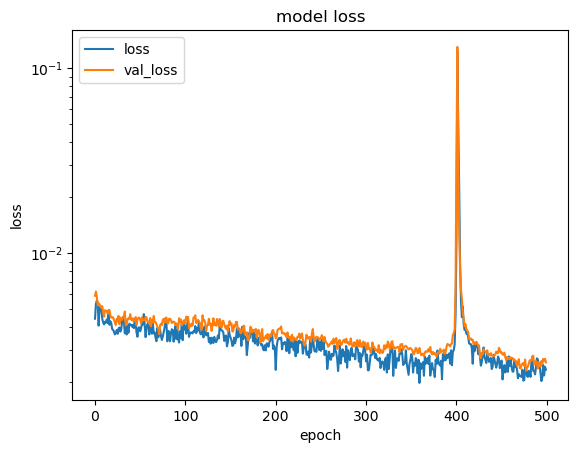

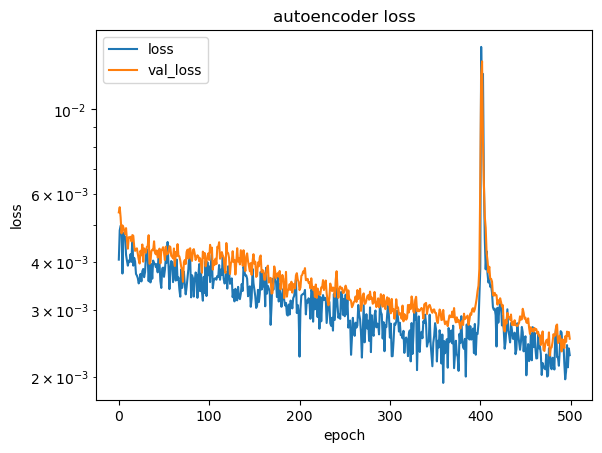

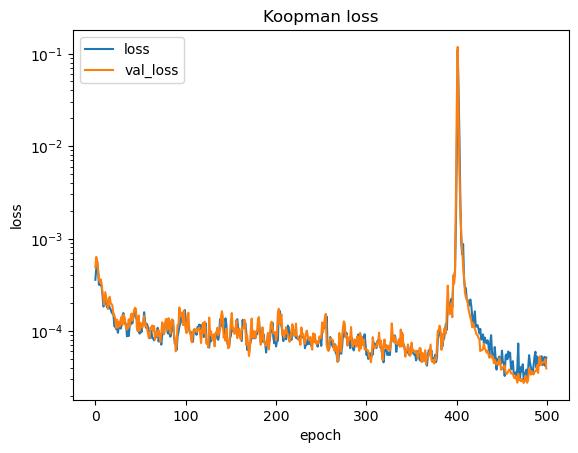

In [65]:
plt.plot(history.history[key[0]])
plt.plot(history.history[key[3]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(history.history[key[1]])
plt.plot(history.history[key[4]])
plt.title('autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()

plt.plot(history.history[key[2]])
plt.plot(history.history[key[5]])
plt.title('Koopman loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['loss','val_loss'])
plt.show()

In [76]:
x_recon = model_auto(x_train_para)
y_recon = model_auto(y_train_para)

In [77]:
x_recon-y_recon

<tf.Tensor: shape=(9192, 466), dtype=float32, numpy=
array([[-0.00291924, -0.00374499, -0.0027224 , ..., -0.00176045,
         0.00106977, -0.00121588],
       [ 0.01348351, -0.00100448, -0.00275427, ...,  0.00647599,
        -0.01277834,  0.01342553],
       [ 0.00152214,  0.0009111 ,  0.00369987, ...,  0.00073701,
        -0.00252968,  0.00249243],
       ...,
       [-0.00125396,  0.00352333,  0.00174282, ...,  0.01579773,
        -0.01000667,  0.01192099],
       [ 0.00343631, -0.00281803,  0.00057447, ..., -0.00580619,
         0.00369358, -0.00260168],
       [ 0.00187661,  0.00224227,  0.00362688, ..., -0.00310713,
        -0.0001235 , -0.00062433]], dtype=float32)>